#### Funding

In [ ]:
def get_thresholds():
    data = []
    with open('./bot/config/thresholds.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

In [ ]:
from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI

import pandas as pd
import polars as pl
import numpy as np
# pd.options.display.float_format = '{:.2f}'.format
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

from bot.utils.files import get_saved_coins

In [ ]:
async def get_data(symbol, interval, n_iters, exchange):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df[f'{exchange}_linear'].sort_index()
    return df.dropna()

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [ ]:
exchange = 'bybit'

token_list = [
            '1INCH_USDT',
            'ACH_USDT', 'ADA_USDT', 'AGLD_USDT', 'ALGO_USDT', 'APT_USDT', 'ARB_USDT', 'ARKM_USDT', 'ATOM_USDT',
            'BLUR_USDT',
            'CELO_USDT', 'CHZ_USDT', 'CRV_USDT',
            'DOGE_USDT', 'DOT_USDT', 'DRIFT_USDT', 'DYDX_USDT',
            'EGLD_USDT', 'ENA_USDT', 'ETHFI_USDT', 'FARTCOIN_USDT', 'FLOW_USDT',
            'GALA_USDT', 'GLM_USDT', 'GMT_USDT', 'GRT_USDT',
            'HBAR_USDT', 'IMX_USDT', 'INJ_USDT', 'IOTA_USDT',
            'JASMY_USDT', 'JUP_USDT', 'KAS_USDT', 'KSM_USDT',
            'LDO_USDT', 'LPT_USDT',
            'MANA_USDT', 'MANTA_USDT', 'MORPHO_USDT', 'MOVE_USDT',
            'NEAR_USDT', 'NXPC_USDT',
            'ONDO_USDT', 'OP_USDT', 'ORDI_USDT',
            'PNUT_USDT', 'POL_USDT', 'RENDER_USDT', 'ROSE_USDT', 'RUNE_USDT',
            'S_USDT', 'SAND_USDT', 'SEI_USDT', 'STRK_USDT',
            'STX_USDT', 'SUI_USDT', 'SUSHI_USDT',
            'THETA_USDT', 'TIA_USDT', 'TON_USDT', 'TRX_USDT', 'VET_USDT',
            'WIF_USDT', 'XLM_USDT', 'XRP_USDT', 'ZRX_USDT'
              ]

syms = [col[:-5] for col in token_list]

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

start_date = datetime.now().replace(microsecond=0) - timedelta(days=60)
end_date = None

for symbol in syms:
    fund_hist = await exc_manager.get_funding_history(symbol=f'{symbol}_USDT', start_date=start_date, limit=500)
    fund_hist = fund_hist[0]

    fund_sum = float(fund_hist['funding'].sum())
    fund_len = fund_hist['funding'].shape[0]

    hour_df = await get_data(symbol=f'{symbol}_USDT', interval='1h', n_iters=5, exchange=exchange)
    hour_df = hour_df.tail(4320) # Берём последние пол года
    hour_df.drop(['Exchange', 'Market_type'], axis=1, inplace=True)
    daily_df = await get_data(symbol=f'{symbol}_USDT', interval='1d', n_iters=1, exchange=exchange)
    daily_df = daily_df.tail(180) # Берём последние пол года

    hour_df['Max_range'] = hour_df['High'] - hour_df['Low']
    hour_df['Max_range_perc'] = (hour_df['High'] - hour_df['Low']) / hour_df['Low'] * 100
    hour_10 = hour_df[hour_df['Max_range_perc'] > 10].shape[0]
    hour_10_perc = 100 * hour_10 / hour_df.shape[0]
    hour_atr = hour_df['Max_range'].mean()
    hour_atr_perc = hour_df['Max_range_perc'].mean()
    hour_mtr_perc = hour_df['Max_range_perc'].max()

    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100
    days_10 = daily_df[daily_df['Max_range_perc'] > 10].shape[0]
    days_10_perc = 100 * days_10 / daily_df.shape[0]
    day_atr = daily_df['Max_range'].mean()
    day_atr_perc = daily_df['Max_range_perc'].mean()
    day_mtr_perc = daily_df['Max_range_perc'].max()

    print(f'========= {symbol} =========')
    print(f'Суммарный фандинг: {fund_sum * 100:.2f}%, расчётов по фандингу: {fund_len}')
    print(f'Фандинг. min: {fund_hist['funding'].min() * 100}%; max: {fund_hist['funding'].max() * 100}%')
    print()
    print(f'ATR за 1 день: {day_atr:.4f} ({day_atr_perc:.2f}%); за 1 час: {hour_atr:.4f} ({hour_atr_perc:.2f}%)')
    print(f'MaxTR за 1 день: {day_mtr_perc:.2f}%; за 1 час: {hour_mtr_perc:.2f}%')
    print(f'Колебания цены более 10%. Дни: {days_10} ({days_10_perc:.1f}%); Часы: {hour_10} ({hour_10_perc:.1f}%)')
    print()

In [ ]:
daily_df

#### Бектест одной торговой пары

In [1]:
from bot.analysis.backtesting import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df
from bot.utils.pair_trading import get_lr_zscore, get_dist_zscore, get_qty, calculate_profit, get_tls_zscore
from bot.analysis.strategy_analysis import analyze_strategy
from statsmodels.tsa.stattools import adfuller, coint

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [51]:
token_1 = 'ARKM'
token_2 = 'MANTA'
min_order = 42
leverage = 2

valid_length = 12
train_length = 10
pairs = pl.read_parquet('./data/pair_selection/all_pairs.parquet')
try:
    curr_pair = pairs.filter((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
    std_1 = pairs['std_1'][0]
    std_2 = pairs['std_2'][0]
except IndexError:
    curr_pair = pairs.filter((pl.col('coin1') == token_2) & (pl.col('coin2') == token_1))
    std_1 = pairs['std_2'][0]
    std_2 = pairs['std_1'][0]

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))

tf = '1h'
winds = np.array([64, 72, 96, 120])

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

In [52]:
df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
print(f'{token_1:>8} first date: {df_1['time'][0]}')
print(f'{token_2:>8} first date: {df_2['time'][0]}')

tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
agg_df = make_trunc_df(tick_df, timeframe=tf, token_1=token_1, token_2=token_2, method='triple')

dist_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='dist')
lr_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='lr')
tls_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, 
                             median_length=6, spr_method='tls')

search_space = [(tf, int(w)) for w in winds]

    ARKM first date: 2025-11-06 00:00:00+03:00
   MANTA first date: 2025-11-06 00:00:00+03:00


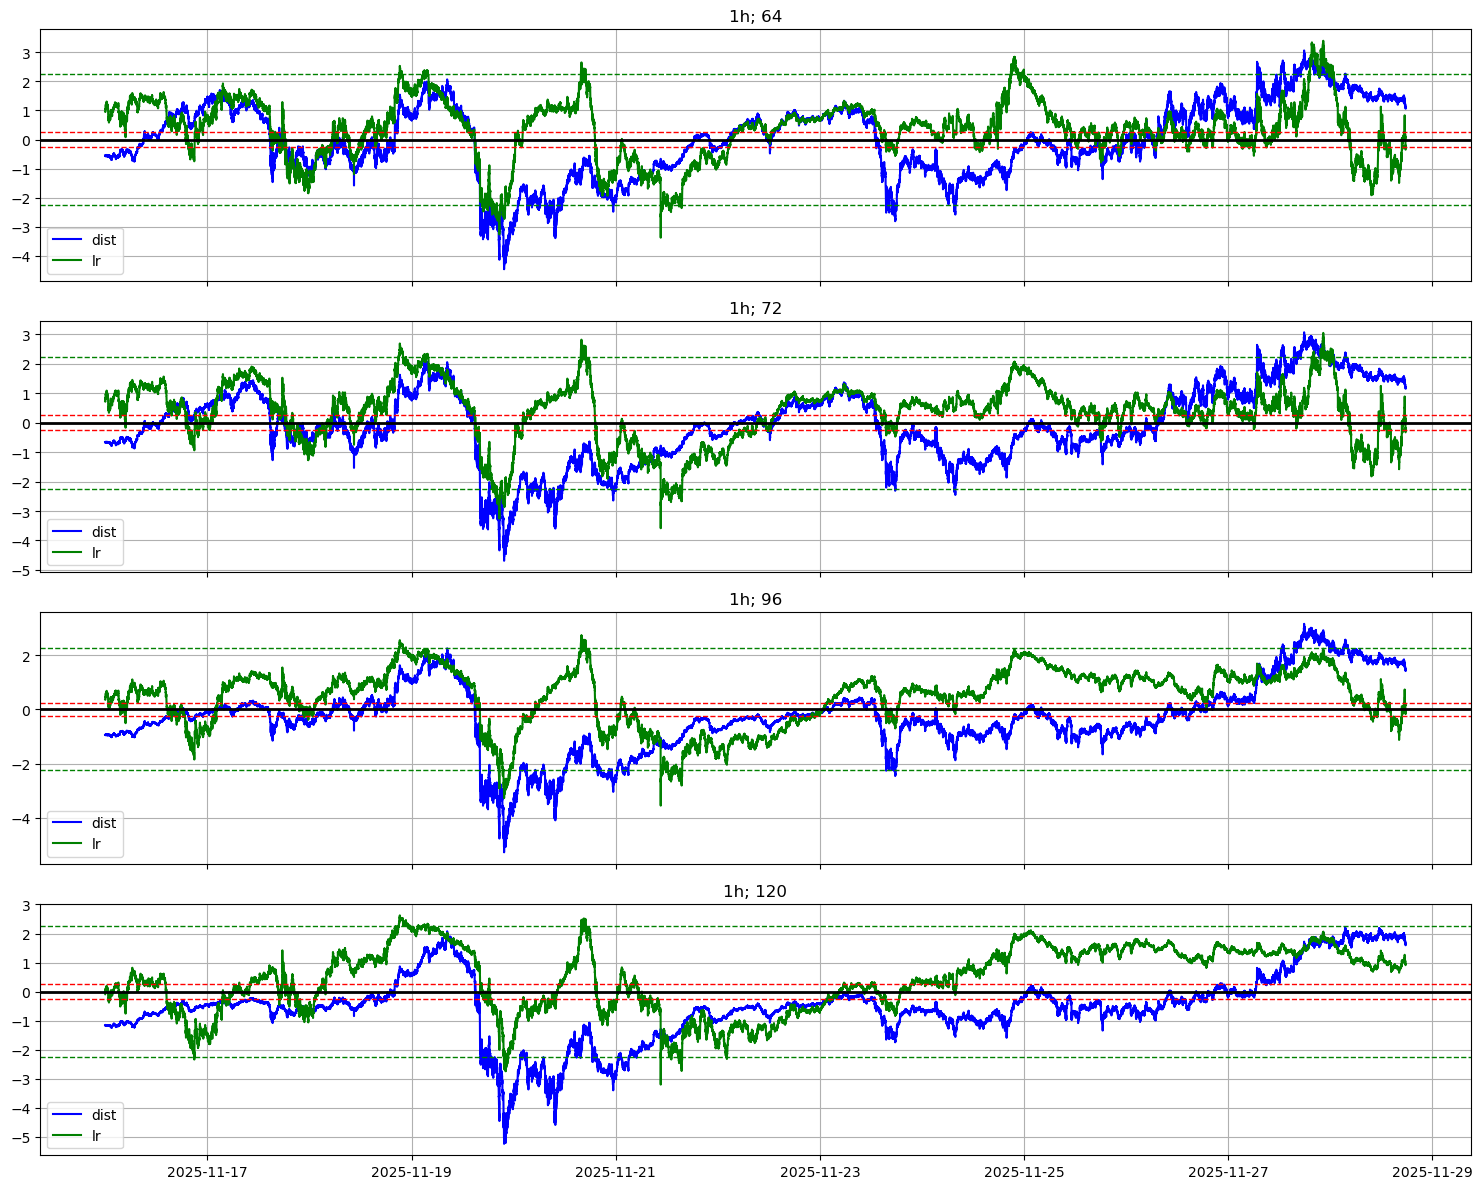

In [53]:
fig, ax = plt.subplots(nrows=len(winds), ncols=1, sharex=True, figsize=(15, 3*len(winds)))
for i, w in enumerate(winds):
    ax[i].plot(dist_df['time'], dist_df[f'z_score_{w}_{tf}'], c='blue', label='dist')
    ax[i].plot(lr_df['time'], lr_df[f'z_score_{w}_{tf}'], c='green', label='lr')
    ax[i].axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax[i].axhline(y=-2.25, color='green', linestyle='--', linewidth=1)
    ax[i].axhline(y=2.25, color='green', linestyle='--', linewidth=1)
    ax[i].axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    ax[i].grid()
    ax[i].set_title(f'{tf}; {w}')
    ax[i].legend()
fig.tight_layout()

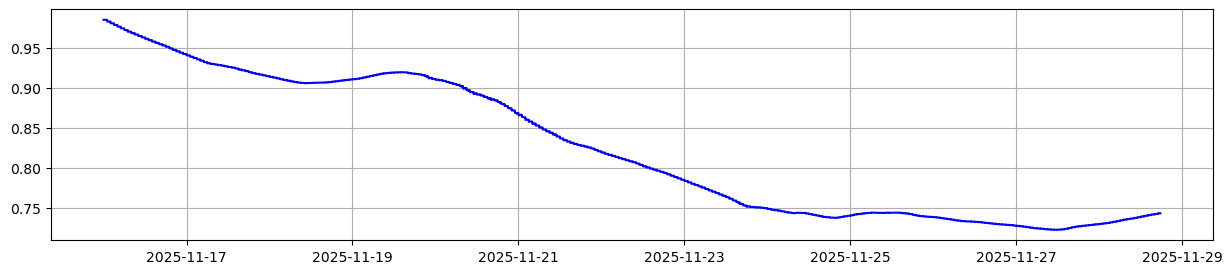

In [56]:
plt.figure(figsize=(15,3))
plt.plot(dist_df['time'], dist_df[f'spread_mean_96_{tf}'], c='blue', label='dist')
plt.grid();

In [55]:
def run_backtest(dist_df, params):
    end_date = dist_df['time'][-1]
    tf = params['tf']
    wind = params['wind']
    qty_method = params['qty_method']
    std_1 = params.get('std_1', None)
    std_2 = params.get('std_2', None)
    close_method = params['close_method']
    sl_std = params['sl_std']

    dist_df = dist_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
             f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_2}_bid_price', f'{token_2}_ask_price',
             f'spread_mean_{wind}_{tf}', f'spread_std_{wind}_{tf}', f'z_score_{wind}_{tf}'
        ).rename({f"spread_mean_{wind}_{tf}": "spread_mean", 
                  f"spread_std_{wind}_{tf}": "spread_std", 
                  f"z_score_{wind}_{tf}": "z_score"})
    
    trades_dist = backtest(dist_df, token_1, token_2, dp_1, dp_2,
                -params['thresh_in'], -params['thresh_out'], params['thresh_in'], params['thresh_out'],
                long_possible=True, short_possible=True, dist_in=0, dist_out=0,
                balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
                fee_rate=0.001, sl_std=sl_std, sl_dist=1.0, sl_method='leave', close_method=close_method,
                leverage=leverage, verbose=2)
    # if trades_dist.height > 0:
    #     metrics_dist = analyze_strategy(trades_dist, start_date=valid_time, end_date=end_date, initial_balance=100.0)
    #     print(f'Max drawdown: {metrics_dist["max_drawdown"]}; profit_ratio: {metrics_dist["profit_ratio"]}')
    

In [11]:
params = {'tf': '1h', 'wind': 72, 'thresh_in': 2.25, 'thresh_out': 0.1, 'qty_method': 'usdt_neutral',
         'std_1': std_1, 'std_2': std_2, 'sl_std': 8.0, 'close_method': 'regular'
         }

run_backtest(dist_df, params)

low_in: -2.25; high_in: 2.25; low_out: -0.1; high_out: 0.1. n_trades: 3.Profit: 8.49.
[ Open] 2025-11-19 16:06:20. Buy 360 ARKM, Sell 863.1 MANTA
[STOP LOSS!] 2025-11-19 21:38:15. Profit: -11.66
[ Open] 2025-11-20 23:12:20. Buy 380 ARKM, Sell 732.0 MANTA
[Close] 2025-11-22 06:27:15. Profit: 10.57
[ Open] 2025-11-23 17:41:50. Buy 419 ARKM, Sell 801.4 MANTA
[Close] 2025-11-25 01:34:35. Profit: 9.59
[ Open] 2025-11-27 06:44:55. Sell 394 ARKM, Buy 841.3 MANTA


In [ ]:
dist_df['z_score_72_1h'].min()

In [ ]:
# token_1 = 'ARKM'
# token_2 = 'MANTA'
# valid_time = datetime(2025, 11, 27, 8, 30, 0, tzinfo=ZoneInfo('Europe/Moscow'))
# end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))

In [12]:
def get_sensitivity(z_score_arr, profit_array):
    dz = np.diff(z_score_arr)
    dvu = np.diff(profit_array)
    
    mask = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001)
    mask_pos = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz > 0)
    mask_neg = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz < 0)
    
    dvu_dz = dvu[mask] / dz[mask]
    dvu_dz_pos = dvu[mask_pos] / dz[mask_pos]
    dvu_dz_neg = dvu[mask_neg] / dz[mask_neg]

    return np.mean(dvu_dz), np.mean(dvu_dz_pos), np.mean(dvu_dz_neg)

def get_corr(z_score_array, profit_array, n_obs=1_000_00):
    z_arr = z_score_array[~np.isnan(z_score_array)][-n_obs:]
    pr_arr = profit_array[~np.isnan(profit_array)][-n_obs:]
    return np.corrcoef(z_arr, pr_arr)[0][1]

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [35]:
token_1 = 'ARKM'
token_2 = 'MANTA'

tf = '1h'
wind = 96
close_method = 'reg' # 'fix' or 'reg'

test_in = 1.6
in_ = 2.25
out_ = 0.25
delete_dist = 0.2
fee_rate = 0.001
sl_std = 8.0

# end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
# valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)

valid_length = 3
train_length = 5

valid_time = datetime(2025, 11, 19, 14, 1, 1, tzinfo=ZoneInfo('Europe/Moscow'))
end_time   = datetime(2025, 11, 22, 12, 20, 34, tzinfo=ZoneInfo('Europe/Moscow'))
start_time = valid_time - timedelta(days=train_length)
start_ts   = int(datetime.timestamp(valid_time))

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

In [36]:
min_order = 42

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)

agg_df = make_trunc_df(df, timeframe=tf, token_1=token_1, token_2=token_2, method='triple')
dist_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, np.array([wind]), min_order, start_ts, 
                             median_length=6, spr_method='dist')

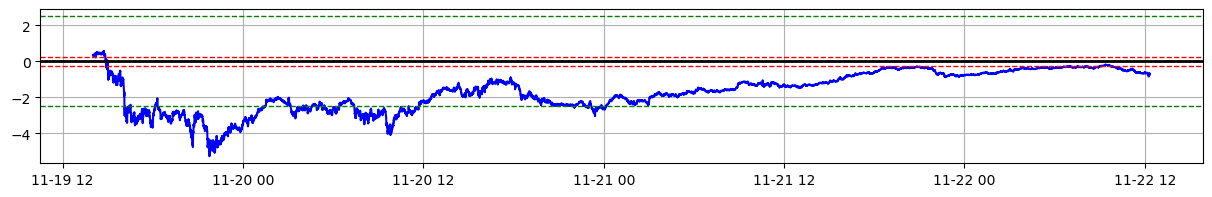

In [37]:
plt.figure(figsize=(15, 2))
plt.plot(dist_df['time'], dist_df[f'z_score_{wind}_{tf}'], c='blue', label='dist')
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
plt.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
plt.grid();

In [38]:
time_arr = dist_df['time'].to_numpy()
tss = dist_df['ts'].to_numpy()
price1 = dist_df[token_1].to_numpy()
price2 = dist_df[token_2].to_numpy()
bid_1 = dist_df[f"{token_1}_bid_price"].to_numpy()
ask_1 = dist_df[f"{token_1}_ask_price"].to_numpy()
bid_2 = dist_df[f"{token_2}_bid_price"].to_numpy()
ask_2 = dist_df[f"{token_2}_ask_price"].to_numpy()

hist_ts = agg_df['ts'].to_numpy()
hist_t1 = agg_df[token_1].to_numpy()
hist_t2 = agg_df[token_2].to_numpy()

In [39]:
%%time
nrows = tss.shape[0]
ts_arr = np.full(nrows, np.nan)
z_score_arr = np.full(nrows, np.nan)
tls_z_score_arr = np.full(nrows, np.nan)
fixed_z_arr = np.full(nrows, np.nan)
fixed_tls_z_arr = np.full(nrows, np.nan)
profit_arr = np.full(nrows, np.nan)
spread_arr = np.full(nrows, np.nan)
corr_arr = np.full(nrows, np.nan)
mask = (np.abs(z_score_arr) >= 0.0001) & (np.abs(profit_arr) >= 0.0001)  & (np.abs(fixed_z_arr) >= 0.0001)

full_dist_spread = np.full(nrows, np.nan)
full_tls_spread = np.full(nrows, np.nan)

tracking_long = dict()
tracking_short = dict()

POS_NONE, POS_LONG, POS_SHORT = 0, 1, 2

pos_side = POS_NONE
side_1, side_2 = '', ''
qty_1, qty_2 = 0.0, 0.0
best_zscore = 0
test_price_1, test_price_2 = None, None
open_price_1, open_price_2 = None, None
fixed_mean, fixed_std = None, None
fixed_tls_mean, fixed_tls_std = None, None
z_arr = []

for i in range(nrows):
    t1_price = price1[i]
    t2_price = price2[i]
    close_price_1 = ask_1[i] if side_1 == 'short' else bid_1[i]
    close_price_2 = ask_2[i] if side_1 == 'long' else bid_2[i]

    # Выберем из агрегированных цен только те, которые были до текущего момента
    mask = hist_ts < tss[i]
    t1_hist = hist_t1[mask][-2 * wind:]
    t2_hist = hist_t2[mask][-2 * wind:]

    # Сформируем массивы, в которых к историческим данным в конец добавим текущую медианную цену, и посчитаем z_score
    t1_arr_med = np.append(t1_hist, t1_price)
    t2_arr_med = np.append(t2_hist, t2_price)

    spread_mean, spread_std, zscore = get_dist_zscore(t1_arr_med[-wind:], t2_arr_med[-wind:], np.array([wind]))
    spread = np.log(t1_price) - np.log(t2_price)
    z_score = zscore[0]
    tm = datetime.fromtimestamp(tss[i])

    tls_spr, tls_spr_mean, tls_spr_std, tls_alpha, tls_beta, tls_zscore = get_tls_zscore(t1_arr_med, t2_arr_med, np.array([wind]))
    tls_zscore = tls_zscore[0]
    tls_spr = tls_spr[0]

    full_dist_spread[i] = spread
    full_tls_spread[i] = tls_spr
        
    # ------------ Обработка входа в позицию ------------
    if pos_side == POS_NONE:
        # Если эта пара токенов ещё не отслеживается
        if z_score < -test_in and (token_1, token_2) not in tracking_long:
            print(f'{tm} Начинаем отслеживать long-пару {token_1} - {token_2}')
            
            fixed_mean, fixed_std = spread_mean[0], spread_std[0]
            fixed_tls_mean, fixed_tls_std = tls_spr_mean[0], tls_spr_std[0]
            print(f'{tm} Фиксируем среднее значение спреда {fixed_mean:.4f} и std {fixed_std:.4f}')
            test_price_1 = ask_1[i]
            test_price_2 = bid_2[i]
            side_1 = 'long'
            side_2 = 'short'
            qty_1, qty_2 = get_qty(token_1, token_2, test_price_1, test_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')
            fees = (qty_1 * test_price_1 + qty_2 * test_price_2) * fee_rate * 2
            
            tracking_long[(token_1, token_2)] = [[z_score], [-fees]]
        elif z_score > test_in and (token_1, token_2) not in tracking_short:
            print(f'{tm} Начинаем отслеживать short-пару {token_1} - {token_2}')

            fixed_mean, fixed_std = spread_mean[0], spread_std[0]
            fixed_tls_mean, fixed_tls_std = tls_spr_mean[0], tls_spr_std[0]
            print(f'{tm} Фиксируем среднее значение спреда {fixed_mean:.4f} и std {fixed_std:.4f}')
            
            test_price_1 = bid_1[i]
            test_price_2 = ask_2[i]
            side_1 = 'short'
            side_2 = 'long'
            qty_1, qty_2 = get_qty(token_1, token_2, test_price_1, test_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')
            fees = (qty_1 * test_price_1 + qty_2 * test_price_2) * fee_rate * 2
            tracking_short[(token_1, token_2)] = [[z_score], [-fees]]
            
        # Обновляем z_score и profit для потенциальной long-позиции
        if (token_1, token_2) in tracking_long:
            z_arr = tracking_long[(token_1, token_2)][0]
            best_zscore = min(z_arr)
            
            curr_profit_1 = calculate_profit(test_price_1, bid_1[i], qty_1, side_1)
            curr_profit_2 = calculate_profit(test_price_2, ask_2[i], qty_2, side_2)
            curr_profit = curr_profit_1 + curr_profit_2
            tracking_long[(token_1, token_2)][0].append(z_score)
            tracking_long[(token_1, token_2)][1].append(curr_profit)

            fixed_z_score = (spread - fixed_mean) / fixed_std
            fixed_z_arr[i] = fixed_z_score
            tls_z_score_arr[i] = tls_zscore

            fixed_tls_z_score = (tls_spr - fixed_tls_mean) / fixed_tls_std
            fixed_tls_z_arr[i] = fixed_tls_z_score
            
            # Если z_score выходит из зоны входа в позицию, перестаём отслеживать пару
            if z_score > -test_in + delete_dist and pos_side == POS_NONE:
                print(f'{tm} Удаляем пару {token_1} - {token_2} из трекинга (z_score: {z_score:.3f})')
                curr_profit_1 = 0
                curr_profit_2 = 0
                curr_profit = 0
                tracking_long.pop((token_1, token_2))
                test_price_1, test_price_2 = None, None
                z_arr = []
                continue
            
            if z_score < -in_:
                print(f'{tm} Открываем лонг-позицию. z_score: {z_score:.3f}')

                z_score_array = np.array(z_arr)
                profit_array = np.array(tracking_long[(token_1, token_2)][1])

                dvu_dz, dvu_dz_pos, dvu_dz_neg = get_sensitivity(z_score_array, profit_array)
                print(f'Чуствительность: {dvu_dz:.3f}; pos: {dvu_dz_pos:.3f}; neg: {dvu_dz_neg:.3f}')

                open_price_1 = ask_1[i]
                open_price_2 = bid_2[i]
                side_1 = 'long'
                side_2 = 'short'
                qty_1, qty_2 = get_qty(token_1, token_2, open_price_1, open_price_2, None, coin_information, 
                           200, 0.001, None, None, method='usdt_neutral')

                fees = (qty_1 * open_price_1 + qty_2 * open_price_2) * fee_rate * 2
                pos_side = POS_LONG
                tracking_long.pop((token_1, token_2))
                z_score_array, profit_array, z_arr, pr_arr, corr_usdt = None, None, None, None, None
                test_price_1, test_price_2 = None, None
                z_arr = []
                continue
            
        # Обновляем z_score и profit для потенциальной short-позиции
        elif (token_1, token_2) in tracking_short:
            z_arr = tracking_short[(token_1, token_2)][0]
            best_zscore = max(z_arr)

            curr_profit_1 = calculate_profit(test_price_1, ask_1[i], qty_1, side_1)
            curr_profit_2 = calculate_profit(test_price_2, bid_2[i], qty_2, side_2)
            curr_profit = curr_profit_1 + curr_profit_2
            
            tracking_short[(token_1, token_2)][0].append(z_score)
            tracking_short[(token_1, token_2)][1].append(curr_profit)

            fixed_z_score = (spread - fixed_mean) / fixed_std
            fixed_z_arr[i] = fixed_z_score
            tls_z_score_arr[i] = tls_zscore

            fixed_tls_z_score = (tls_spr - fixed_tls_mean) / fixed_tls_std
            fixed_tls_z_arr[i] = fixed_tls_z_score
            
            # Если z_score выходит из зоны входа в позицию, перестаём отслеживать пару
            if z_score < test_in - delete_dist and pos_side == POS_NONE:
                print(f'{tm} Удаляем пару {token_1} - {token_2} из трекинга (z_score: {z_score:.3f})')
                curr_profit_1 = 0
                curr_profit_2 = 0
                curr_profit = 0
                tracking_short.pop((token_1, token_2))
                test_price_1, test_price_2 = None, None
                z_arr = []
                continue
            
            if z_score > in_:
                print(f'{tm} Открываем шорт-позицию. z_score: {z_score:.3f}')
                
                z_score_array = np.array(tracking_short[(token_1, token_2)][0])
                profit_array = np.array(tracking_short[(token_1, token_2)][1])

                dvu_dz, dvu_dz_pos, dvu_dz_neg = get_sensitivity(z_score_array, profit_array)
                print(f'Чуствительность: {dvu_dz:.3f}; pos: {dvu_dz_pos:.3f}; neg: {dvu_dz_neg:.3f}')

                open_price_1 = bid_1[i]
                open_price_2 = ask_2[i]
                side_1 = 'short'
                side_2 = 'long'
                qty_1, qty_2 = get_qty(token_1, token_2, open_price_1, open_price_2, None, coin_information, 
                           200, 0.001, None, None, method='usdt_neutral')

                fees = (qty_1 * open_price_1 + qty_2 * open_price_2) * fee_rate * 2
                
                
                pos_side = POS_SHORT
                tracking_short.pop((token_1, token_2))
                z_score_array, profit_array, z_arr, pr_arr, corr_usdt = None, None, None, None, None
                test_price_1, test_price_2 = None, None
                z_arr = []
                continue
            
    
    # ------------ Обработка выхода из позиции ------------
    if pos_side == POS_LONG:
        curr_profit_1 = calculate_profit(open_price_1, bid_1[i], qty_1, side_1)
        curr_profit_2 = calculate_profit(open_price_2, ask_2[i], qty_2, side_2)
        curr_profit = curr_profit_1 + curr_profit_2

        z_score_arr[i] = z_score
        tls_z_score_arr[i] = tls_zscore
        profit_arr[i] = curr_profit
        spread_arr[i] = spread
        
        fixed_z_score = (spread - fixed_mean) / fixed_std
        fixed_z_arr[i] = fixed_z_score
        
        fixed_tls_z_score = (tls_spr - fixed_tls_mean) / fixed_tls_std
        fixed_tls_z_arr[i] = fixed_tls_z_score

        # Сохраняем текущую корреляцию
        zsc = z_score_arr[~np.isnan(z_score_arr)]
        pr = spread_arr[~np.isnan(spread_arr)]
        corr_arr[i] = np.corrcoef(zsc, pr)[0][1]
        
        out_condition = z_score if close_method == 'reg' else fixed_z_score
        
        # Проверяем стоп-лосс
        if abs(fixed_z_score) > sl_std:
            print(f'{tm} STOP-LOSS! Закрываем long-позицию. z_score: {z_score:.3f}, fixed z_score: {fixed_z_score:.3f}, profit: {curr_profit:.2f}')
            break
        
        if out_condition > out_:
            print(f'{tm} Закрываем long-позицию. z_score: {z_score:.3f}, profit: {curr_profit:.2f}')
            pos_side = POS_NONE
            open_price_1, open_price_2, qty_1, qty_2 = None, None, None, None
            fixed_mean, fixed_std = None, None
            side_1, side_2 = '', ''
            continue
    
    if pos_side == POS_SHORT:
        curr_profit_1 = calculate_profit(open_price_1, ask_1[i], qty_1, side_1)
        curr_profit_2 = calculate_profit(open_price_2, bid_2[i], qty_2, side_2)
        curr_profit = curr_profit_1 + curr_profit_2
        
        z_score_arr[i] = z_score
        tls_z_score_arr[i] = tls_zscore
        profit_arr[i] = curr_profit
        spread_arr[i] = spread
        
        fixed_z_score = (spread - fixed_mean) / fixed_std
        fixed_z_arr[i] = fixed_z_score
        
        fixed_tls_z_score = (tls_spr - fixed_tls_mean) / fixed_tls_std
        fixed_tls_z_arr[i] = fixed_tls_z_score
        
        # Сохраняем текущую корреляцию
        zsc = z_score_arr[~np.isnan(z_score_arr)]
        pr = spread_arr[~np.isnan(spread_arr)]
        corr_arr[i] = np.corrcoef(zsc, pr)[0][1]

        out_condition = z_score if close_method == 'reg' else fixed_z_score

        # Проверяем стоп-лосс
        if abs(fixed_z_score) > sl_std:
            print(f'{tm} STOP-LOSS! Закрываем short-позицию. z_score: {z_score:.3f}, fixed z_score: {fixed_z_score:.3f}, profit: {curr_profit:.2f}')
            break
        if out_condition < -out_:
            print(f'{tm} Закрываем шорт-позицию. z_score: {z_score:.3f}, profit: {curr_profit:.2f}')
            pos_side = POS_NONE
            open_price_1, open_price_2, qty_1, qty_2 = None, None, None, None
            fixed_mean, fixed_std = None, None
            side_1, side_2 = '', ''
            continue


2025-11-19 16:03:45 Начинаем отслеживать long-пару ARKM - MANTA
2025-11-19 16:03:45 Фиксируем среднее значение спреда 0.9189 и std 0.0189
2025-11-19 16:06:00 Открываем лонг-позицию. z_score: -2.627
Чуствительность: 1.992; pos: 2.134; neg: 1.904
2025-11-19 21:38:10 STOP-LOSS! Закрываем long-позицию. z_score: -4.745, fixed z_score: -8.278, profit: -11.02
CPU times: total: 797 ms
Wall time: 573 ms


In [40]:
mask = (np.abs(z_score_arr) >= 0.0001) & (np.abs(profit_arr) >= 0.0001)  & (np.abs(fixed_z_arr) >= 0.0001)
zsc = z_score_arr[mask]
spr = spread_arr[mask]
pr = profit_arr[mask]
fxz = fixed_z_arr[mask]
cr = corr_arr[~np.isnan(corr_arr)]
tls_zsc = tls_z_score_arr[mask]
tls_fxz = fixed_tls_z_arr[mask]

dz = np.diff(zsc)
dpr = np.diff(pr)
eps = 0.0000001
mask = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps)
mask_pos = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps) & (dz > 0)
mask_neg = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps) & (dz < 0)

dpr_dz = dpr[mask] / dz[mask]
dpr_dz_pos = dpr[mask_pos] / dz[mask_pos]
dpr_dz_neg = dpr[mask_neg] / dz[mask_neg]

avg_dpr_dz = moving_average(dpr_dz, n=120)
avg_pos_dz = moving_average(dpr_dz_pos, n=120)
avg_neg_dz = moving_average(dpr_dz_neg, n=120)

In [41]:
def plot_spread():
    x = range(len(zsc))

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(14, 14))
    ax1.plot(x, zsc, c='blue', label='z_score')
    ax1.plot(x, fxz, c='gray', label='fixed z_score')
    ax1.plot(x, tls_zsc, c='green', label='tls z_score')
    ax1.plot(x, tls_fxz, c='red', label='fixed tls')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
    ax1.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
    # ax1.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    # ax1.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    ax1.set_title('z_score')
    ax1.grid();
    ax1.legend()
    
    ax2.plot(x, pr, c='red')
    ax2.grid()
    ax2.set_title('Profit')
    
    ax3.set_title('Sensitivity')
    ax3.plot(range(len(avg_pos_dz)), avg_pos_dz, c='green', label='positive')
    ax3.plot(range(len(avg_neg_dz)), avg_neg_dz, c='red', label='negative')
    ax3.legend()
    # ax3.set_ylim(-50, 50)
    ax3.grid();
    
    ax4.plot(x, spr)
    ax4.set_title('Spread')
    ax4.grid()

    ax5.set_title('TLS Spread')
    ax5.plot(range(len(full_tls_spread)), full_tls_spread)
    ax5.grid()

    ax6.plot(range(len(cr)), cr, c='green', label='corr', linewidth=2)
    ax6.set_title('Correlation')
    ax6.set_ylim(-1, 1)
    ax6.grid()
    
    fig.tight_layout()

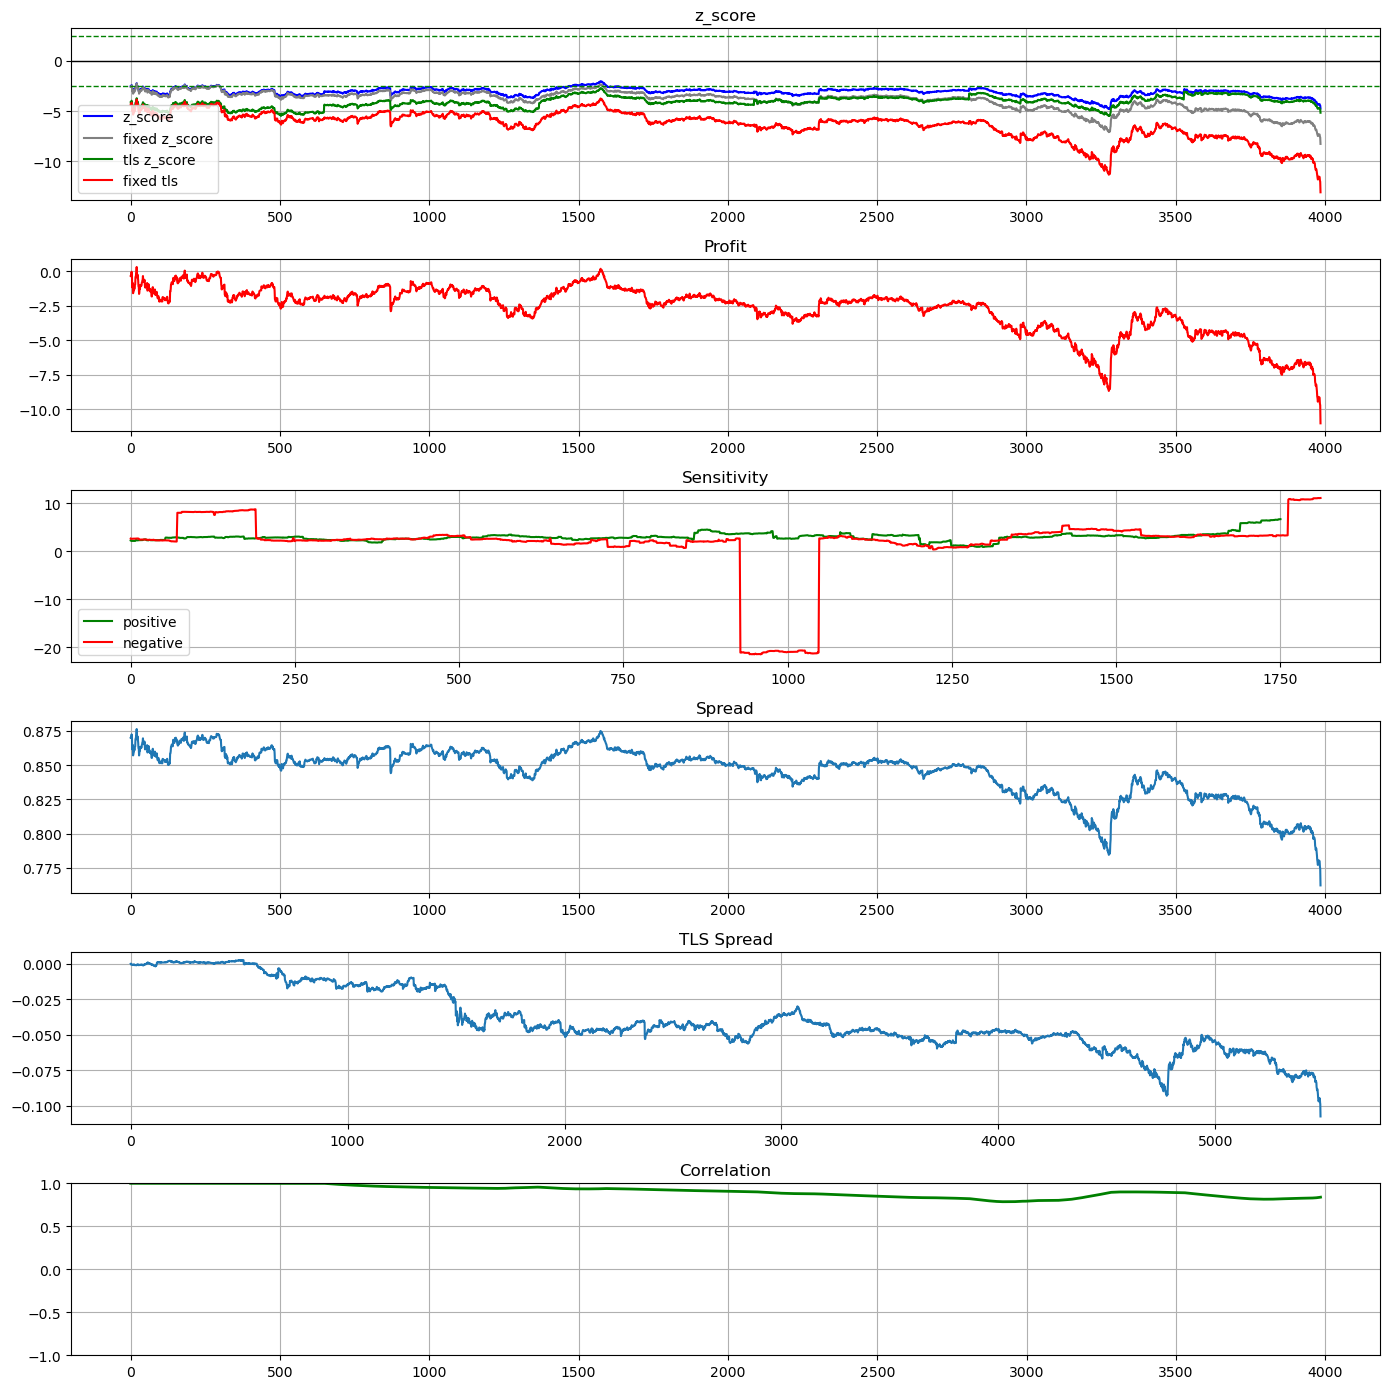

In [42]:
plot_spread()

In [43]:
fxz.min()

np.float64(-8.277776724702676)

In [ ]:
corr_usdt = np.corrcoef(zsc, pr)[0][1]
corr_usdt

In [ ]:
np.mean(dpr_dz), np.mean(dpr_dz_pos), np.mean(dpr_dz_neg)

In [ ]:
len(dpr_dz_pos),len(dpr_dz_neg)

In [ ]:
len(dpr_dz_pos) * np.mean(dpr_dz_pos) - len(dpr_dz_neg) * np.mean(dpr_dz_neg)

In [ ]:
dpr_dz_pos.sum(), -dpr_dz_neg.sum()

In [ ]:
zsc

In [ ]:
start, stop = 240, 360
round(float(dz[start:stop].sum()), 4), round(float(dpr[start:stop].sum()), 4)

In [ ]:
0.3311 / 0.193, -0.7224 / -0.4186, 0.0645/0.0649

In [ ]:
fig, ax1 = plt.subplots(figsize=(4, 4))
ax1.scatter(dz, dpr)
ax1.grid();

In [ ]:
len(z_score_array), len(profit_array)

In [ ]:
n = 50

fig, ax1 = plt.subplots(1, 1, figsize=(15, 3))
ax1.plot(range(n), z_score_array[-n:], label=f'z_score', c='blue')
ax1.set_ylabel('z_score')
ax2 = ax1.twinx()
ax2.plot(range(n), profit_array[-n:], label=f'profit', c='green')
ax2.set_ylabel('usdt')
plt.tight_layout()

In [ ]:
token_1 = 'ARKM'
token_2 = 'MANTA'

open_time = datetime(2025, 11, 27, 8, 30, 0, tzinfo=ZoneInfo('Europe/Moscow'))
close_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
open_ts = int(datetime.timestamp(open_time))
close_ts = int(datetime.timestamp(close_time))

z_score_hist = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', open_ts, close_ts)
len(z_score_hist)

In [ ]:
z_score_hist.tail(2)

In [ ]:
tdf = dist_df.filter((pl.col('time') >= open_time) & (pl.col('time') <= close_time))

fig, ax1 = plt.subplots(figsize=(14, 3))
ax1.plot(tdf['time'], tdf[f'z_score_{wind}_{tf}'], c='blue', label='calc z_score')
ax1.plot(z_score_hist['time'], z_score_hist['z_score'], c='green', label='real z_score')
ax1.plot(z_score_hist['time'], z_score_hist['fixed_z_score'], c='gray', label='fixed z_score')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax1.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
ax1.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
ax1.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
ax1.axhline(y=0.25, color='red', linestyle='--', linewidth=1)

ax2 = ax1.twinx()
ax2.plot(z_score_hist['time'], z_score_hist['profit'], c='red', label='profit')

ax1.grid();
plt.legend();

In [ ]:
tdf = z_score_hist.filter(pl.col('fixed_z_score') > -10)

In [ ]:
tdf.select('z_score','profit', 'fixed_z_score', 'spread').corr()

In [ ]:
z_score_hist = z_score_hist.with_columns(
    pl.rolling_corr(
        a="z_score",         # Первый столбец
        b="profit",          # Второй столбец
        window_size=720,     # Размер скользящего окна
        ddof=1               # Степени свободы для дисперсии
    ).alias("rolling_corr")
)

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 3))
ax1.plot(z_score_hist['time'], z_score_hist['rolling_corr'])
ax1.grid();

# ax2 = ax1.twinx()
# ax2.plot(range(len(r_corr)), r_corr, c='red', label='numpy')

#### Анализ совершённых сделок

In [ ]:
orders = pl.read_ndjson('./logs/trades.jsonl')

token_1 = 'APT'
token_2 = 'FIL'

ot = "2025-09-16 17:07:14"
ct = "2025-09-16 23:09:17"

open_ = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'open') & (pl.col('ct') == ot))
close = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'close') & (pl.col('ct') == ct))

In [ ]:
open_.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
close.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
max_position_size = 200
leverage = 2
tf = open_['tf'][0]
wind = open_['wind'][0]

side = open_['side'][0]
side_2 = 'short' if side == 'long' else 'long'
beta = open_['beta'][0]
t1_open = open_['t1'].to_numpy()[0]
t2_open = open_['t2'].to_numpy()[0]
t1_close = close['t1'].to_numpy()[0]
t2_close = close['t2'].to_numpy()[0]

t1_op = open_['t1_ask_price'][0] if side == 'long' else open_['t1_bid_price'][0]
t2_op = open_['t2_bid_price'][0] if side == 'long' else open_['t2_ask_price'][0]
t1_cl = close['t1_bid_price'][0] if side == 'long' else close['t1_ask_price'][0]
t2_cl = close['t2_ask_price'][0] if side == 'long' else close['t2_bid_price'][0]

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_open, token_2: t2_open}), token_1, token_2, wind, method='lr').tail(2)

In [ ]:
train_len = 80
wind = 10
winds = np.array((wind,))
tf = '4h'
median_length = 6
min_order = 50

train_time = datetime(2025, 9, 12, 17, 0, tzinfo=ZoneInfo("Europe/Moscow"))
start_time = datetime(2025, 9, 16, 17, 7, 14, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 16, 23, 9, 17, tzinfo=ZoneInfo("Europe/Moscow"))

start_ts = int(datetime.timestamp(start_time))

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)

avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=train_time)
agg_df = make_trunc_df(avg_df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')

df_sec = make_trunc_df(avg_df, timeframe='1s', token_1=token_1, token_2=token_2,
                       start_date=start_time - timedelta(seconds=6),
                       end_date = end_time + timedelta(seconds=6),
                       method='last', return_bid_ask=True)
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)

df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
     f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
     f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
     'z_score').filter(
        (pl.col('time') >= start_time) & (pl.col('time') <= end_time)
     )

In [ ]:
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)


In [ ]:
t1_op, t1_cl

In [ ]:
t2_op, t2_cl

In [ ]:
qty_1, qty_2 = get_qty(token_1, token_2, t1_op, t2_op, beta, coin_information, max_position_size * leverage,
                          method='usdt_neutral')
qty_1, qty_2

In [ ]:
pr_1 = calculate_profit(open_price=t1_op, close_price=t1_cl, n_coins=qty_1, side=side)
pr_2 = calculate_profit(open_price=t2_op, close_price=t2_cl, n_coins=qty_2, side=side_2)
pr_1, pr_2, pr_1 + pr_2

In [ ]:
t1_op, t1_cp

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_close, token_2: t2_close}), token_1, token_2, wind, method='lr').tail(1)

In [ ]:
qty_1 = 10881
qty_2 = 4375

open_spread = -0.000066
close_spread = 0.000021
open_mean = 0.000015
open_std = 0.00005

t1_bid_ask_spread = open_['t1_ask_price'][0] - open_['t1_bid_price'][0]
t2_bid_ask_spread = open_['t2_ask_price'][0] - open_['t2_bid_price'][0]
beta = open_['beta'][0]
z_score = open_['z_score'][0]
fee_rate = 0.00055

In [ ]:
# Доход за 1 стандартное отклонение
profit_per_std = qty_1 * open_std
profit_per_std

In [ ]:
# Считаем профит
spread_profit = abs(open_spread - (open_mean + 0.5 * open_std))
real_spread_profit = (close_spread - open_spread) * qty_1
spread_profit * qty_1, real_spread_profit

In [ ]:
# Комиссия за 4 сделки, каждая на 200$ (100$ с плечом 2)
fees = 4 * 200 * fee_rate

# Bid-ask spread
bid_ask_slippage = t1_bid_ask_spread * qty_1 + t2_bid_ask_spread * qty_2
fees, bid_ask_slippage

#### Обработка больших датафреймов

In [ ]:
from tqdm.notebook import tqdm
import polars as pl
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bot.utils.files import load_config

config = load_config('./bot/config/config.yaml')

method = config['spr_method']
start_time = config['valid_time']
end_time = config['end_time']

In [ ]:
token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))
len(token_pairs)

In [ ]:
# --- Создание объединённого датафрейма из нескольких ---
tfs = ('1h', )
method = 'dist'

time_series = pl.datetime_range(start=start_time, end=end_time, interval="5s", eager=True)
main_df = pl.DataFrame({'time': time_series})

for token_1, token_2 in tqdm(token_pairs):
    try:
        spread_df = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_1h_{method}.parquet', 
                low_memory=True, rechunk=True, use_pyarrow=True).filter(
                (pl.col('time') >= start_time) & (pl.col('time') < end_time)
            )

        cols_to_rn = [col for col in spread_df.columns for tf in tfs if col.endswith(tf)]
        prefix = f"{token_1}_{token_2}_"
        mapping = {c: f"{prefix}{c}" for c in cols_to_rn}
        spread_df = spread_df.rename(mapping)

        cols_to_drop = [col for col in spread_df.columns if col in main_df.columns]
        cols_to_drop.remove('time')
        spread_df = spread_df.drop(cols_to_drop)

        main_df = main_df.join(spread_df, on='time', how='full', coalesce=True)
    except FileNotFoundError:
        print(f'FileNotFoundError: {token_1} - {token_2}')
        continue

In [ ]:
spr_cols = [col for col in main_df.columns if 'spread' in col]
main_df.drop(spr_cols).tail(3)

In [ ]:
main_df.tail(10)

In [ ]:
main_df[1:-1].drop(spr_cols).write_parquet('./data/train_data.parquet')

In [ ]:
# --- Код для склеивания по частям двух датафреймов, записанных на диске, в один ---
import polars as pl

df_1 = pl.read_parquet('./data/test_1.parquet', low_memory=True, use_pyarrow=True)
df_2 = pl.read_parquet('./data/test_2.parquet', low_memory=True, use_pyarrow=True)
print(df_1.shape, df_2.shape)

full_df = df_1.join(df_2[:, :500], on='time', how='full', coalesce=True)
full_df.write_parquet(f'./data/full_1.parquet')

cols_to_drop = df_2[:, :500].columns
cols_to_drop.remove('time')
df_2 = df_2.drop(cols_to_drop)
print(full_df.shape, df_2.shape)

df_2.write_parquet(f'./data/full_2.parquet')

In [ ]:
token_1 = 'JUP'
token_2 = 'MANA'
method = 'dist'

In [ ]:
pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet', 
                low_memory=True, rechunk=True, use_pyarrow=True)